In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pycraf.conversions as cnv
from pycraf.antenna import *
from astropy import units as u

In [2]:
from ska.constellation import Constellation #### ska constellation package
import scepter
from scepter import skynet,obs

In [3]:
tel_az, tel_el, grid=skynet.pointpop(niters=1000)


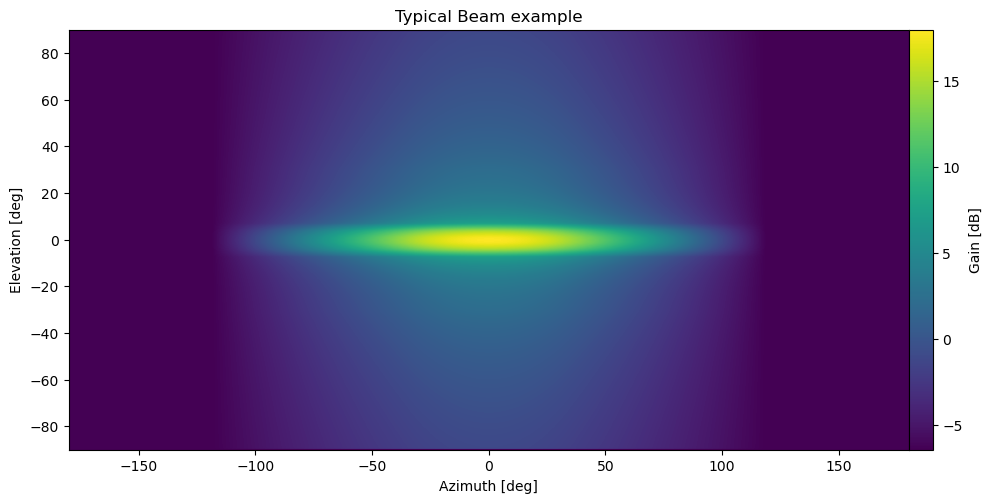

In [4]:
azims = np.arange(-180, 180.1, 0.5) * u.deg
elevs = np.arange(-90, 90.1, 0.5) * u.deg

G0 = 18. * cnv.dB
phi_3db = 65. * u.deg
# theta_3db can be inferred in the following way:
theta_3db = 31000 / G0.to(cnv.dimless) / phi_3db.value * u.deg
k_p, k_h, k_v = (0.7, 0.7, 0.3) * cnv.dimless
tilt_m, tilt_e = (0, 0) * u.deg  #### mechanical and electrical tilt angles

bs_gains = imt_advanced_sectoral_peak_sidelobe_pattern_400_to_6000_mhz(
    azims[np.newaxis], elevs[:, np.newaxis],
    G0, phi_3db, theta_3db,
    k_p, k_h, k_v,
    tilt_m=tilt_m, tilt_e=tilt_e,
    ).to(cnv.dB).value

fig = plt.figure(figsize=(12, 6))

ax = fig.add_axes((0.15, 0.1, 0.7, 0.7))
cax = fig.add_axes((0.85, 0.1, 0.02, 0.7))

im = ax.imshow(
    bs_gains,
    extent=(azims[0].value, azims[-1].value, elevs[0].value, elevs[-1].value),
    origin='lower', cmap='viridis',
    )
ax.set_title("Typical Beam example")
plt.colorbar(im, cax=cax)
cax.set_ylabel('Gain [dB]')
ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Elevation [deg]')
plt.show()

In [5]:
import requests
import cysgp4
from cysgp4 import PyTle, PyObserver
from cysgp4 import get_example_tles, propagate_many
url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
ctrak_starlink = requests.get(url).text


# Need to convert them to a list of tuples (each tuple consisting
# of the three TLE strings)
tle_list = cysgp4.tle_tuples_from_text(ctrak_starlink)

In [6]:
tles = np.array([
    PyTle(*tle) for tle in tle_list
    ])[np.newaxis, :500, np.newaxis]  # use first 20 TLEs
observers = np.array([
    # PyObserver(6.88375, 0.525, 0.366),
    PyObserver(6.88375, 50.525, 0.366),
    ])[ np.newaxis, np.newaxis,:]
mjds = np.linspace(
    58805.5, 58806.5, 1000  # 1000 time steps
    )[:, np.newaxis, np.newaxis]

result = propagate_many(mjds, tles, observers, on_error='coerce_to_nan')
print(sorted(result.keys()))

['eci_pos', 'eci_vel', 'geo', 'topo']


TypeError: Argument 'phi' to function 'ras_pattern' has no 'unit' attribute. You may want to pass in an astropy Quantity instead.